In [253]:
from numpy import load
from numpy import array
import numpy as np

import pandas as pd
from pandas import read_csv

from keras.layers import Input, Conv2D
from keras.models import Model
from keras.layers import Dense, Conv1D, Flatten
from keras.models import model_from_json
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Flatten, Dense, Activation
from keras.utils import np_utils
from keras.layers import concatenate

import sklearn.metrics as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt
import pickle
from multiprocessing import Queue
from h5py import File

import xgboost as xgb
from bayes_opt import BayesianOptimization
import os
import ast 
from itertools import chain
import cv2
from tqdm import tqdm

 # Loading & Preprocessing

In [254]:
data = load('/Users/ipsitapraharaj/Desktop/CERN/histos_tba.20.npz')
lst = data.files
di = []
for item in lst:
    di.append(data[item])

In [255]:
orig_data = pd.DataFrame(di[0])
orig_data['y'] = pd.DataFrame(di[1])[0]
data = pd.DataFrame(di[0])

Pre- processing Removing unwanted columns and NaN rows
& Bining of absolute values of pt

In [256]:
col = list(filter(lambda x: x%12<5, list(range(84))))
col = list(filter(lambda x: (x-1)%12!=0, col))
col = sorted(list(set(col).difference(list(range(36,47))+list(range(72,83)))))

data = pd.concat([data[col],orig_data.iloc[:,-4:]],axis=1)
data = data.dropna()

data['label'] = abs(1/data['y'])
bins = list(range(0,120))
labels = list(range(len(bins)-1))
data['label'] = pd.cut(data['label'], bins=bins, labels=labels)
data = data.reset_index(drop=True)

X, y = data.iloc[:,:-2],(data.iloc[:,-2])
X = (X-X.min())/(X.max()-X.min())

In [257]:
e = np.digitize(1/(abs(y)),bins)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify = e )

preparing normalized dataset for model

Text(0.5, 0, '1/pt values ')

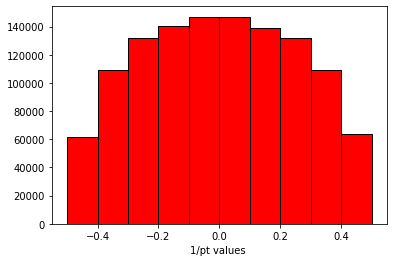

In [258]:
plt.hist(data['y'],color='red',edgecolor='black')
plt.xlabel('1/pt values ')
# for i in range(len(bins)-1):
#     print("bin "+ str(i)+" ---> "+ str(bins[i])+" GeV to "+str(bins[i+1])+" GeV")

 # XGB

In [259]:
params = pd.read_csv('/Users/ipsitapraharaj/Desktop/CERN/params_20.csv', index_col = 0)
params = params.loc[0,:].to_dict()
params['max_depth'] = int(params['max_depth'])

for binwise prediction 

In [26]:
def xgb_model(i):
    
    data_new = data[1/abs(data.y)>= bins[i]]
    X_new, y_new = data_new.iloc[:,:-2],data_new.iloc[:,-2]
    X_new = (X_new-X_new.min())/(X_new.max()-X_new.min())
    
    e = np.digitize(y_new,bins)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=123, stratify = e )
    dtrain = xgb.DMatrix(data=X_train,label=y_train)
    dtest = xgb.DMatrix(data=X_test,label=y_test)

    # Train a new model with the best parameters from the search
    model2 = xgb.train(params, dtrain, num_boost_round=25)

    # Predict on testing and training set
    y_pred = model2.predict(dtest)
    y_train_pred = model2.predict(dtrain)
    
    acc = round(accuracy_score(np.digitize(1/(abs(y_test)), bins), np.digitize(1/(abs(y_pred)), bins)),4)
    mae = round(sm.mean_absolute_error(y_test, y_pred), 4)
#     f1 = f1_score(np.digitize(1/(abs(y_test)), bins), np.digitize(1/(abs(y_pred[:,0])), bins), average=None)

    return acc, mae, y_test, y_pred, y_train, y_train_pred

In [29]:
xgb_results = np.array([xgb_model(i) for i in tqdm(range(len(bins)))])

  3%|▎         | 4/120 [03:23<1:32:22, 47.78s/it]<ipython-input-26-e01b9c4b165b>:19: RuntimeWarning: divide by zero encountered in true_divide
  acc = round(accuracy_score(np.digitize(1/(abs(y_test)), bins), np.digitize(1/(abs(y_pred)), bins)),4)
 82%|████████▎ | 99/120 [08:55<00:17,  1.22it/s] <ipython-input-26-e01b9c4b165b>:19: RuntimeWarning: divide by zero encountered in true_divide
  acc = round(accuracy_score(np.digitize(1/(abs(y_test)), bins), np.digitize(1/(abs(y_pred)), bins)),4)
 98%|█████████▊| 117/120 [09:07<00:01,  1.60it/s]<ipython-input-26-e01b9c4b165b>:19: RuntimeWarning: divide by zero encountered in true_divide
  acc = round(accuracy_score(np.digitize(1/(abs(y_test)), bins), np.digitize(1/(abs(y_pred)), bins)),4)
100%|██████████| 120/120 [09:10<00:00,  4.59s/it]


In [209]:
pd.DataFrame(xgb_results)

,0,1,2,3,4,5
0,0.3732,0.0438,51404 0.233459 662673 -0.420489 206865...,"[0.26055324, -0.40712076, -0.42893374, 0.00218...",779758 0.029018 814439 0.001726 816147...,"[-0.007893503, -0.049520314, 0.25705037, 0.435..."
1,0.3732,0.0438,51404 0.233459 662673 -0.420489 206865...,"[0.26055324, -0.40712076, -0.42893374, 0.00218...",779758 0.029018 814439 0.001726 816147...,"[-0.007893503, -0.049520314, 0.25705037, 0.435..."
2,0.3732,0.0438,51404 0.233459 662673 -0.420489 206865...,"[0.26055324, -0.40712076, -0.42893374, 0.00218...",779758 0.029018 814439 0.001726 816147...,"[-0.007893503, -0.049520314, 0.25705037, 0.435..."
3,0.3042,0.0387,802234 -0.091832 485274 0.237037 854538...,"[-0.15305829, 0.2763192, -0.23017609, 0.258514...",724702 0.157713 613325 -0.010821 502314 ...,"[0.14246982, 0.0029364228, 0.00565356, 0.10434..."
4,0.2301,0.0349,1063161 0.032580 198759 0.123749 746672...,"[0.002265364, 0.14961705, -0.18605405, 0.20867...",257652 -0.129023 1097829 -0.145961 803094...,"[-0.08747846, -0.1450594, 0.14813632, 0.005217..."
...,...,...,...,...,...,...
115,0.9687,0.0044,1024145 0.008312 530984 0.000768 987068...,"[6.401539e-05, -0.0009562969, 0.0005669594, 0....",1107283 -0.000467 1023436 0.001048 112431...,"[6.401539e-05, 0.00017109513, -5.1140785e-05, ..."
116,0.9742,0.0044,865569 0.005334 396956 0.006277 300183...,"[0.00083076954, 0.000106692314, 3.489852e-05, ...",989378 0.002318 75186 0.007075 785888...,"[0.0014711618, 3.489852e-05, 9.089708e-06, 0.0..."
117,0.9867,0.0042,1129235 -0.004569 381841 0.007669 112984...,"[3.3795834e-05, 3.3795834e-05, -1.5318394e-05,...",618378 0.007829 105339 -0.005719 883912...,"[-0.00017249584, -8.34465e-05, 0.00044319034, ..."
118,0.9924,0.0042,528501 -0.008168 298161 -0.001166 198177 ...,"[0.00055518746, -0.00015413761, 0.00048801303,...",314302 0.005520 105894 0.003689 534571...,"[0.00054219365, -1.2278557e-05, -0.0001320839,..."


Text(0.5, 0, 'acc for 1/pt values predicted')

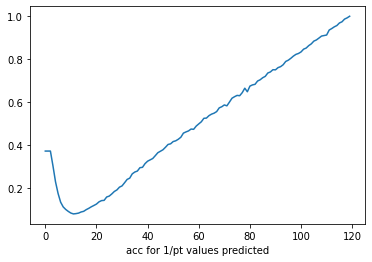

In [121]:
plt.plot(np.array(pd.DataFrame(xgb_results)[0])) #acc
plt.xlabel('acc for 1/pt values predicted')

Text(0.5, 0, 'Mae for 1/pt values predicted')

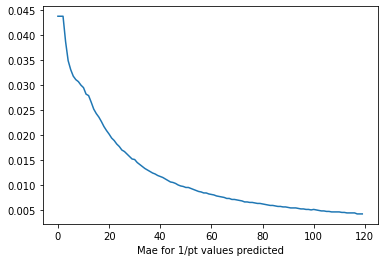

In [120]:
plt.plot(np.array(pd.DataFrame(xgb_results)[1])) #mae
plt.xlabel('Mae for 1/pt values predicted')

Run this to see the data above

In [106]:
np.savez('/Users/ipsitapraharaj/Desktop/CERN/xgb_results', acc= xgb_results[:,0], mae = xgb_results[:,1],y_test = xgb_results[:,2],y_pred= xgb_results[:,3],y_train= xgb_results[:,4],y_train_pred= xgb_results[:,5]) # save
# new_num_arr = np.load('/Users/ipsitapraharaj/Desktop/CERN/data.npz') # load

In [107]:
# np.savez('temp_arra.npz', x=x, y=y)
print("Load arrays from the 'temp_arra.npz' file:")
with np.load('/Users/ipsitapraharaj/Desktop/CERN/xgb_results.npz',allow_pickle=True) as dats:
    acc = dats['acc']
    mae = dats['mae']
    y_test = dats['y_test']
    y_pred = dats['y_pred']
    y_train = dats['y_train']
    y_train_pred = dats['y_train_pred']
    print(acc)
    print(mae)

Load arrays from the 'temp_arra.npz' file:
[0.3732 0.3732 0.3732 0.3042 0.2301 0.176 0.1355 0.1136 0.1016 0.0926
 0.085 0.081 0.0824 0.0847 0.09 0.093 0.1008 0.107 0.1142 0.1203 0.1267
 0.1371 0.1429 0.144 0.1597 0.1639 0.1739 0.1854 0.1925 0.2054 0.2112
 0.226 0.2414 0.2472 0.2673 0.2757 0.2803 0.2959 0.2977 0.3148 0.3261
 0.3323 0.3385 0.3517 0.3655 0.3723 0.3792 0.391 0.4039 0.4069 0.4174
 0.4209 0.4281 0.4375 0.4566 0.4622 0.4669 0.4756 0.4743 0.4893 0.4995
 0.5093 0.5255 0.5265 0.5379 0.5449 0.5494 0.5567 0.574 0.5793 0.5877
 0.5835 0.6009 0.6189 0.626 0.632 0.6305 0.6447 0.6654 0.6489 0.6751
 0.6808 0.6835 0.6988 0.7046 0.7141 0.7205 0.7361 0.741 0.7514 0.7509
 0.7611 0.7657 0.7745 0.7898 0.7956 0.8045 0.8147 0.8228 0.827 0.8342
 0.847 0.8521 0.8634 0.8716 0.8844 0.8898 0.8986 0.9078 0.9103 0.9127
 0.9359 0.9428 0.9508 0.9568 0.9687 0.9742 0.9867 0.9924 1.0]
[0.0438 0.0438 0.0438 0.0387 0.0349 0.0331 0.0318 0.0311 0.0307 0.03
 0.0295 0.0282 0.0279 0.0266 0.0252 0.0243 0.0236 0.02

# XGB (pt)

In [109]:
def xgb_model_pt(i):
    
    data_new = data[1/abs(data.y)>= bins[i]]
    X_new, y_new = data_new.iloc[:,:-2],1/(data_new.iloc[:,-2])
    X_new = (X_new-X_new.min())/(X_new.max()-X_new.min())
    
    e = np.digitize(y_new,bins)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=123, stratify = e )
    dtrain = xgb.DMatrix(data=X_train,label=y_train)
    dtest = xgb.DMatrix(data=X_test,label=y_test)

    # Train a new model with the best parameters from the search
    model2 = xgb.train(params, dtrain, num_boost_round=25)

    # Predict on testing and training set
    y_pred = model2.predict(dtest)
    y_train_pred = model2.predict(dtrain)
    
    acc = round(accuracy_score(np.digitize(1/(abs(y_test)), bins), np.digitize(1/(abs(y_pred)), bins)),4)
    mae = round(sm.mean_absolute_error(y_test, y_pred), 4)
    
    return acc, mae, y_test, y_pred, y_train, y_train_pred

In [110]:
xgb_results_pt = np.array([xgb_model_pt(i) for i in tqdm(range(len(bins)))])

100%|██████████| 120/120 [06:02<00:00,  3.02s/it]


  0%|          | 0/1 [1:13:48<?, ?it/s]


Text(0.5, 0, 'Acc for pt values predicted')

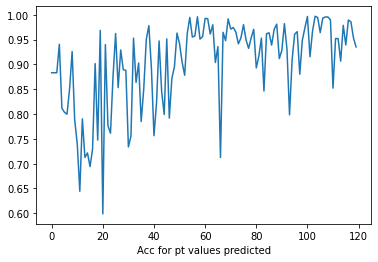

In [118]:
plt.plot(np.array(pd.DataFrame(xgb_results_pt)[0])) #acc
plt.xlabel('Acc for pt values predicted')

Text(0.5, 0, 'Mae for pt values predicted')

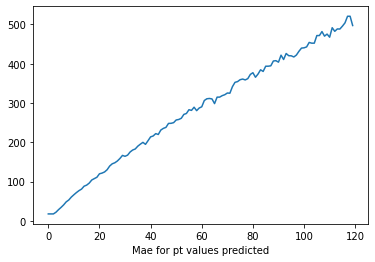

In [119]:
plt.plot(np.array(pd.DataFrame(xgb_results_pt)[1])) #mae
plt.xlabel('Mae for pt values predicted')

In [113]:
np.savez('/Users/ipsitapraharaj/Desktop/CERN/xgb_results_pt', acc= xgb_results_pt[:,0], mae = xgb_results_pt[:,1],y_test = xgb_results_pt[:,2],y_pred= xgb_results_pt[:,3],y_train= xgb_results_pt[:,4],y_train_pred= xgb_results_pt[:,5]) # save

In [114]:
# np.savez('temp_arra.npz', x=x, y=y)
print("Load arrays from the 'temp_arra.npz' file:")
with np.load('/Users/ipsitapraharaj/Desktop/CERN/xgb_results_pt.npz',allow_pickle=True) as dats:
    acc = dats['acc']
    mae = dats['mae']
    y_test = dats['y_test']
    y_pred = dats['y_pred']
    y_train = dats['y_train']
    y_train_pred = dats['y_train_pred']
    print(acc)
    print(mae)

Load arrays from the 'temp_arra.npz' file:
[0.8831 0.8831 0.8831 0.9404 0.8118 0.8035 0.7996 0.8505 0.9257 0.7879
 0.7398 0.6444 0.7903 0.7126 0.7216 0.6941 0.7299 0.9016 0.7475 0.9685
 0.5988 0.9397 0.7765 0.7613 0.8767 0.9621 0.8532 0.929 0.8895 0.8878
 0.7338 0.7555 0.9528 0.8636 0.9027 0.7849 0.8505 0.9505 0.978 0.8919
 0.7563 0.8227 0.9472 0.8455 0.799 0.9513 0.7918 0.8719 0.8954 0.963
 0.9413 0.9047 0.878 0.9618 0.9946 0.955 0.9572 0.9959 0.9509 0.9557
 0.9925 0.992 0.9611 0.9798 0.9038 0.9357 0.7125 0.9645 0.9477 0.9916
 0.9711 0.9742 0.9653 0.9414 0.9532 0.9799 0.9492 0.9322 0.9535 0.9706
 0.8929 0.9164 0.9529 0.8463 0.9616 0.9635 0.9388 0.9707 0.981 0.9117
 0.9283 0.9819 0.9302 0.7984 0.9086 0.9608 0.9658 0.8802 0.9485 0.9733
 0.9965 0.9154 0.9671 0.9969 0.9944 0.9639 0.9932 0.9954 0.9954 0.9896
 0.8521 0.9521 0.9519 0.9065 0.9786 0.9391 0.9893 0.9857 0.9531 0.9351]
[17.6599 17.6599 17.6599 21.9646 28.5044 34.2858 40.6487 48.3203 53.0768
 60.5226 66.4323 71.9934 76.947 80.8467

 # CNN 1D
 Please download the model_cnn1.json & model_cnn1.h5 files to the local directory to run this model
 
 The results are displayed corresponding to each cell

In [267]:
# load json and create model
json_file = open('model_cnn1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model1 = model_from_json(loaded_model_json)
# load weights into new model
loaded_model1.load_weights("model_cnn1.h5")
print("Loaded model from disk")
loaded_model1.compile(loss='mae', optimizer='adam', metrics=['accuracy'])

Loaded model from disk


In [268]:
loaded_model1.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 18, 64)            192       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 17, 64)            8256      
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 16, 64)            8256      
_________________________________________________________________
flatten_7 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 1025      
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________


In [269]:
# x = X.to_numpy().reshape(X.to_numpy().shape[0], X.to_numpy().shape[1], 1)
# print(x.shape)
# x = np.nan_to_num(x)
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)
col1 = [i for i in data.columns if i not in list(range(48,59))]

In [ ]:
data_new = data[1/abs(data.y)>= bins[i]]
data_new = data[col1]
X_new, y_new = data_new.iloc[:,:-2],1/(data_new.iloc[:,-2])
X_new = (X_new-X_new.min())/(X_new.max()-X_new.min())

x = X_new.to_numpy().reshape(X_new.to_numpy().shape[0], X_new.to_numpy().shape[1], 1)
print(x.shape)
x = np.nan_to_num(x)

e = np.digitize(y_new,bins)
X_train, X_test, y_train, y_test = train_test_split(x, y_new, test_size=0.2, random_state=123, stratify = e )

#     Predict on testing and training set
y_pred = loaded_model1.predict(X_test)
y_train_pred = loaded_model1.predict(X_train)


acc = round(accuracy_score(np.digitize(1/(abs(y_test)), bins), np.digitize(1/(abs(y_pred[:,0])), bins)),4)
mae = round(sm.mean_absolute_error(y_test, y_pred[:,0]), 4)

In [274]:
def cnn1_model(i):
    
    data_new = data[1/abs(data.y)>= bins[i]]
    data_new = data[col1]
    X_new, y_new = data_new.iloc[:,:-2],1/(data_new.iloc[:,-2])
    X_new = (X_new-X_new.min())/(X_new.max()-X_new.min())
    
    x = X_new.to_numpy().reshape(X_new.to_numpy().shape[0], X_new.to_numpy().shape[1], 1)
    print(x.shape)
    x = np.nan_to_num(x)
    
    e = np.digitize(y_new,bins)
    X_train, X_test, y_train, y_test = train_test_split(x, y_new, test_size=0.2, random_state=123, stratify = e )

#     Predict on testing and training set
    y_pred = loaded_model1.predict(X_test)
    y_train_pred = loaded_model1.predict(X_train)
    
    
    acc = round(accuracy_score(np.digitize(1/(abs(y_test)), bins), np.digitize(1/(abs(y_pred[:,0])), bins)),4)
    mae = sm.mean_absolute_error(y_test, y_pred[:,0])


    return acc, mae,  y_test, y_pred, y_train, y_train_pred
#     return y_test, y_pred, y_train, y_train_pred


In [275]:
cnn1_results = np.array([cnn1_model(i) for i in tqdm(range(len(bins[5:7])))])


  0%|          | 0/2 [00:00<?, ?it/s]

(1179356, 19, 1)


  0%|          | 0/2 [51:18<?, ?it/s]
<ipython-input-274-af1bd2197e91>:20: RuntimeWarning: divide by zero encountered in true_divide
  acc = round(accuracy_score(np.digitize(1/(abs(y_test)), bins), np.digitize(1/(abs(y_pred[:,0])), bins)),4)

 50%|█████     | 1/2 [00:50<00:50, 50.64s/it]

(1179356, 19, 1)


<ipython-input-274-af1bd2197e91>:20: RuntimeWarning: divide by zero encountered in true_divide
  acc = round(accuracy_score(np.digitize(1/(abs(y_test)), bins), np.digitize(1/(abs(y_pred[:,0])), bins)),4)

100%|██████████| 2/2 [01:39<00:00, 49.72s/it]


# CNN 1d (predicting Pt)

In [245]:
def cnn1_model_pt(i):
    
    
    data_new = data[1/abs(data.y)>= bins[i]]
    data_new = data[col1]
    X_new, y_new = data_new.iloc[:,:-2],1/abs(data_new.iloc[:,-2])
    X_new = (X_new-X_new.min())/(X_new.max()-X_new.min())
    
    x = X_new.to_numpy().reshape(X_new.to_numpy().shape[0], X_new.to_numpy().shape[1], 1)
    print(x.shape)
    x = np.nan_to_num(x)
    
    e = np.digitize(y_new,bins)
    X_train, X_test, y_train, y_test = train_test_split(x, y_new, test_size=0.2, random_state=123, stratify = e )

    # Predict on testing and training set
    y_pred = loaded_model1.predict(X_test)
    y_train_pred = loaded_model1.predict(X_train)
    
    acc = round(accuracy_score(np.digitize(1/(abs(y_test)), bins), np.digitize(1/(abs(y_pred[:,0])), bins)),4)
    mae = round(sm.mean_absolute_error(y_test, y_pred[:,0]), 4)
    f1 = f1_score(np.digitize(1/(abs(y_test)), bins), np.digitize(1/(abs(y_pred[:,0])), bins), average='weighted')


    return acc, mae, f1,  y_test, y_pred, y_train, y_train_pred


In [ ]:
cnn1_results_pt = np.array([cnn1_model_pt(i) for i in tqdm(range(len(bins[5:])))])


  0%|          | 0/116 [00:00<?, ?it/s]<ipython-input-37-2b6fcfb9c8c0>:19: RuntimeWarning: divide by zero encountered in true_divide
  acc = round(accuracy_score(np.digitize(1/(abs(y_test)), bins), np.digitize(1/(abs(y_pred[:,0])), bins)),4)
<ipython-input-37-2b6fcfb9c8c0>:21: RuntimeWarning: divide by zero encountered in true_divide
  f1 = f1_score(np.digitize(1/(abs(y_test)), bins), np.digitize(1/(abs(y_pred[:,0])), bins), average='weighted')

  1%|          | 1/116 [00:55<1:45:42, 55.16s/it]<ipython-input-37-2b6fcfb9c8c0>:19: RuntimeWarning: divide by zero encountered in true_divide
  acc = round(accuracy_score(np.digitize(1/(abs(y_test)), bins), np.digitize(1/(abs(y_pred[:,0])), bins)),4)
<ipython-input-37-2b6fcfb9c8c0>:21: RuntimeWarning: divide by zero encountered in true_divide
  f1 = f1_score(np.digitize(1/(abs(y_test)), bins), np.digitize(1/(abs(y_pred[:,0])), bins), average='weighted')

  2%|▏         | 2/116 [01:46<1:42:46, 54.09s/it]<ipython-input-37-2b6fcfb9c8c0>:19: Runt

In [ ]:
pd.DataFrame(cnn1_results_pt)

In [ ]:
plt.plot(np.array(pd.DataFrame(cnn1_results_pt)[1]))
plt.xlabel('Mae for pt values predicted')

# Ann

In [122]:
# load json and create model
json_file = open('model_ann.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_ann.h5")
print("Loaded model from disk")
loaded_model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])

Loaded model from disk


In [123]:
loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 20)                400       
_________________________________________________________________
dense_6 (Dense)              (None, 13)                273       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 14        
Total params: 687
Trainable params: 687
Non-trainable params: 0
_________________________________________________________________


Please run this cell only after loading the trained model

In [125]:
def ann_model(i):
    
    col1 = [i for i in data.columns if i not in list(range(48,59))]
    data_new = data[1/abs(data.y)>= bins[i]]
    data_new = data[col1]
    X_new, y_new = data_new.iloc[:,:-2],(data_new.iloc[:,-2])
    X_new = (X_new-X_new.min())/(X_new.max()-X_new.min())
    
    e = np.digitize(y_new,bins)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=123, stratify = e )

    # Predict on testing and training set
    y_pred = loaded_model.predict(X_test)
    y_train_pred = loaded_model.predict(X_train)
    
    acc = round(accuracy_score(np.digitize(1/(abs(y_test)), bins), np.digitize(1/(abs(y_pred[:,0])), bins)),4)
    mae = round(sm.mean_absolute_error(y_test, y_pred[:,0]), 4)

    return acc, mae,  y_test, y_pred, y_train, y_train_pred

In [126]:
ann_results = np.array([ann_model(i) for i in tqdm(range(len(bins)))])

100%|██████████| 120/120 [1:13:43<00:00, 36.86s/it]


In [127]:
pd.DataFrame(ann_results)

,0,1,2,3,4,5
0,0.4272,0.0313,51404 0.233459 662673 -0.420489 206865...,"[[0.2656855], [-0.4282038], [-0.47252753], [0....",779758 0.029018 814439 0.001726 816147...,"[[0.04138091], [-0.014184758], [0.23043203], [..."
1,0.4272,0.0313,51404 0.233459 662673 -0.420489 206865...,"[[0.2656855], [-0.4282038], [-0.47252753], [0....",779758 0.029018 814439 0.001726 816147...,"[[0.04138091], [-0.014184758], [0.23043203], [..."
2,0.4272,0.0313,51404 0.233459 662673 -0.420489 206865...,"[[0.2656855], [-0.4282038], [-0.47252753], [0....",779758 0.029018 814439 0.001726 816147...,"[[0.04138091], [-0.014184758], [0.23043203], [..."
3,0.4272,0.0313,51404 0.233459 662673 -0.420489 206865...,"[[0.2656855], [-0.4282038], [-0.47252753], [0....",779758 0.029018 814439 0.001726 816147...,"[[0.04138091], [-0.014184758], [0.23043203], [..."
4,0.4272,0.0313,51404 0.233459 662673 -0.420489 206865...,"[[0.2656855], [-0.4282038], [-0.47252753], [0....",779758 0.029018 814439 0.001726 816147...,"[[0.04138091], [-0.014184758], [0.23043203], [..."
...,...,...,...,...,...,...
115,0.4272,0.0313,51404 0.233459 662673 -0.420489 206865...,"[[0.2656855], [-0.4282038], [-0.47252753], [0....",779758 0.029018 814439 0.001726 816147...,"[[0.04138091], [-0.014184758], [0.23043203], [..."
116,0.4272,0.0313,51404 0.233459 662673 -0.420489 206865...,"[[0.2656855], [-0.4282038], [-0.47252753], [0....",779758 0.029018 814439 0.001726 816147...,"[[0.04138091], [-0.014184758], [0.23043203], [..."
117,0.4272,0.0313,51404 0.233459 662673 -0.420489 206865...,"[[0.2656855], [-0.4282038], [-0.47252753], [0....",779758 0.029018 814439 0.001726 816147...,"[[0.04138091], [-0.014184758], [0.23043203], [..."
118,0.4272,0.0313,51404 0.233459 662673 -0.420489 206865...,"[[0.2656855], [-0.4282038], [-0.47252753], [0....",779758 0.029018 814439 0.001726 816147...,"[[0.04138091], [-0.014184758], [0.23043203], [..."


Text(0.5, 0, 'Mae for pt values predicted')

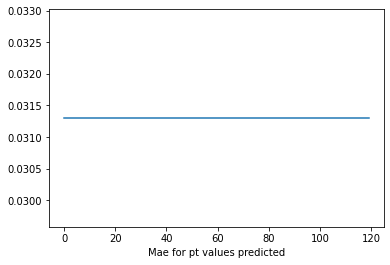

In [128]:
plt.plot(np.array(pd.DataFrame(ann_results)[1]))
plt.xlabel('Mae for pt values predicted')